## Company Background
GoalZone is a fitness club chain providing five types of fitness classes in Canada. Finally, the fitness classes schedule is back to normal after the COVID-19 restrictions are lifted. However, they have received many complaints from the customers about having a hard time booking a fitness class.

From initial analysis, the program operation team found out that the fitness classes are always fully booked but are having a low attendance rate per class. To improve this situation, they would like to increase the class capacity for customers to sign up if a low attendance rate is predicted.  


## Customer Question
The operation manager has asked you to answer the following:
- Can you predict the attendance rate for each fitness class? 



## Dataset


| Column Name                     | Criteria                                                                                                                                                                        |
|---------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Day of Week                     | Character, the day of the week the class was scheduled, one of values from “Mon” to “Sun”.                                                                                      |
| Time                            | Character, the time of the day the class was scheduled, either "AM" or "PM".                                                                                                        |
| Class Category                  | Character, the category of the fitness class, one of “Yoga”, “Aqua”, “Strength”, “HIIT”, or “Cycling”.                                                                          |
| Days Before                     | Numeric, number of days the class stayed fully booked, maximum five days.                                                                                                       |
| Class Capacity                  | Numeric, maximum number of members can sign up for that class, either 15 or 25.  The class capacity being 26 needs to be updated to 25.                                         |
| Attendance                      | Numeric, number of members actually attended the class.                                                                                                                         |
| Average Age                     | Numeric, average age of the members signing up for that class.  Remove rows that average age is smaller than 14 because group fitness class are for members aged 14 and order.  |
| Number of New Students          | Numeric, number of new students signing up for this class.                                                                                                                      |
| Number of Members Over 6 months | Numeric, number of members signing up for the class have been joining the club more than 6 months.                                                                              |                                                                                     |

# Data Validation

### Data Validation: Loading Imports and Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge
plt.style.use('ggplot')

random_state = 123

In [2]:
data = pd.read_csv('data/fitness_class.csv')
data.head()

,day_of_week,time,class_category,class_capacity,days_before,attendance,age,new_students,over_6_month
0,Wed,AM,Yoga,15,1,8,31.1,6,4
1,Sun,PM,Aqua,15,3,8,27.0,7,8
2,Mon,AM,Aqua,15,5,10,22.4,8,7
3,Sun,PM,Strength,25,3,18,23.5,7,9
4,Mon,AM,Yoga,15,5,10,29.8,5,7


### Data Validation: Adding Target Variable and New Features


In [3]:
# Creating Target Variable
data['attendance_rate'] = (data.attendance/data.class_capacity).round(2)
#Renaming features for easier understanding
data.rename(columns={'new_students':'new_member', 'over_6_month':'returning_member'},inplace=True)
#Creating new features to express attendance of new and returning members as rates
data['new_member_rate'] = (data['new_member']/data['class_capacity'])
data['returning_member_rate'] = (data['returning_member']/data['class_capacity']).round(2)
#To better inspect relationship between numeric features in EDA
data["attendance_category"] = pd.cut(data['attendance_rate'],3, labels = ['low', 'medium', 'high'],ordered=True)
data.columns

Index(['day_of_week', 'time', 'class_category', 'class_capacity',
       'days_before', 'attendance', 'age', 'new_member', 'returning_member',
       'attendance_rate', 'new_member_rate', 'returning_member_rate',
       'attendance_category'],
      dtype='object')

### Data Validation: Validating Features 

In [4]:
# validating for any negative numeric values, min/max values, and null values
data_description = data.describe(include = 'all')
data_info = data.info()
display(data.shape,data_description, data_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765 entries, 0 to 764
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   day_of_week            765 non-null    object  
 1   time                   765 non-null    object  
 2   class_category         765 non-null    object  
 3   class_capacity         765 non-null    int64   
 4   days_before            765 non-null    int64   
 5   attendance             765 non-null    int64   
 6   age                    765 non-null    float64 
 7   new_member             765 non-null    int64   
 8   returning_member       765 non-null    int64   
 9   attendance_rate        765 non-null    float64 
 10  new_member_rate        765 non-null    float64 
 11  returning_member_rate  765 non-null    float64 
 12  attendance_category    765 non-null    category
dtypes: category(1), float64(4), int64(5), object(3)
memory usage: 72.7+ KB


(765, 13)

,day_of_week,time,class_category,class_capacity,days_before,attendance,age,new_member,returning_member,attendance_rate,new_member_rate,returning_member_rate,attendance_category
count,765,765,765,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765
unique,7,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,Thu,PM,Yoga,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,medium
freq,127,396,175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,278
mean,NaN,NaN,NaN,17.542484,2.547712,9.563399,29.092680,5.917647,7.577778,0.542941,0.348851,0.443752,NaN
std,NaN,NaN,NaN,4.365481,1.355379,3.896598,5.912063,1.789224,1.974518,0.163211,0.114738,0.117603,NaN
min,NaN,NaN,NaN,15.000000,1.000000,4.000000,8.300000,1.000000,2.000000,0.270000,0.066667,0.130000,NaN
25%,NaN,NaN,NaN,15.000000,1.000000,7.000000,25.300000,5.000000,6.000000,0.400000,0.266667,0.360000,NaN
50%,NaN,NaN,NaN,15.000000,2.000000,9.000000,29.000000,6.000000,8.000000,0.530000,0.333333,0.440000,NaN
75%,NaN,NaN,NaN,25.000000,4.000000,11.000000,33.200000,7.000000,9.000000,0.670000,0.400000,0.530000,NaN


None

### Data Validation: Replacing Out-Of-Range Values

In [5]:
print("Number of classes with class capacity of 26:",len(data[data['class_capacity'] == 26]))
print("Number of members with ages less than 14:",len(data[data['age'] < 14]))

Number of classes with class capacity of 26: 5
Number of members with ages less than 14: 3


In [6]:
data['class_capacity'].replace(26, 25, inplace = True) #replacing class capacity from 25 to 26 
data = data[data['age'] >= 14] #removing ages below 14 

print("Number of classes with class capacity of 26:",len(data[data['class_capacity'] == 26]))
print("Number of members with ages less than 14:",len(data[data['age'] < 14]))

Number of classes with class capacity of 26: 0
Number of members with ages less than 14: 0


### Data Validation: Validating Categorical Features

The features "days_before" and "class_capacity" appear to be numerical but have discrete values meaning they are in fact categorical.

In [7]:
columns = ['day_of_week','time','class_category','days_before','class_capacity', 'attendance_category']
for col in columns:
    print(col,":",sorted(list(data[col].unique())))

day_of_week : ['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed']
time : ['AM', 'PM']
class_category : ['Aqua', 'Cycling', 'HIIT', 'Strength', 'Yoga']
days_before : [1, 2, 3, 4, 5]
class_capacity : [15, 25]
attendance_category : ['high', 'low', 'medium']


### Data Validation: Inspecting for Missing/Duplicated Values

In [8]:
print(data.isnull().sum()) #Checking for null values
print('The number of duplicated values is:',data.duplicated().sum())

day_of_week              0
time                     0
class_category           0
class_capacity           0
days_before              0
attendance               0
age                      0
new_member               0
returning_member         0
attendance_rate          0
new_member_rate          0
returning_member_rate    0
attendance_category      0
dtype: int64
The number of duplicated values is: 0


### Data Validation: Checking changes againist provided Data Dictionary

In [9]:
data.describe(include="all")

,day_of_week,time,class_category,class_capacity,days_before,attendance,age,new_member,returning_member,attendance_rate,new_member_rate,returning_member_rate,attendance_category
count,762,762,762,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762
unique,7,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,Thu,PM,Yoga,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,medium
freq,126,395,173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,278
mean,NaN,NaN,NaN,17.506562,2.547244,9.519685,29.163648,5.912073,7.565617,0.541824,0.349069,0.443819,NaN
std,NaN,NaN,NaN,4.336755,1.355768,3.841164,5.812547,1.788821,1.968617,0.162551,0.114868,0.117824,NaN
min,NaN,NaN,NaN,15.000000,1.000000,4.000000,14.000000,1.000000,2.000000,0.270000,0.066667,0.130000,NaN
25%,NaN,NaN,NaN,15.000000,1.000000,7.000000,25.300000,5.000000,6.000000,0.400000,0.266667,0.360000,NaN
50%,NaN,NaN,NaN,15.000000,2.000000,9.000000,29.000000,6.000000,8.000000,0.530000,0.333333,0.440000,NaN
75%,NaN,NaN,NaN,22.500000,4.000000,11.000000,33.200000,7.000000,9.000000,0.670000,0.400000,0.530000,NaN


# Data Validation: Explanation
Before cleaning, the dataset contained **765 rows and 9 columns** with out-of-range values for the "age" and "class_capacity" columns. There are no missing values in the dataset. I changed the names of 2 columns, "new_students" and "over_6_month" for better understanding and then added two new features based on their values by converting them into rates using the "class_capacity" feature. I also added a feature, "attendance_category" to help with EDA between features. Finally, I added a target variable to represent attendance rate for which we are trying to predict.

- **Day Of The Week**: dtype = object, contains 7 unique values each representing a day of the week.
- **Time**: dtype = object, contains 2 unique values each representing time of the day the class was taken, either AM or PM.
- **Class Category**: dtype = object, contains 5 unique values, where each represents one of the fitness categories.
- **Days Before**: dtype = int64, contains a range of numbers from 1 to 5. Is actually categorical.
- **Class Capacity**: dtype = int64, contains 3 unique values of 15, 25 and 26. The class capacity was replaced from 26 to 25 for the 5 samples in our dataset. Is actually categorical.
- **Attendance**: dtype = int64, contains a range of numbers from 4 to 21. Is actually categorical.
- **Average Age**: dtype = float64, contains a range of values from 8.3 to 48.8. The 3 samples that had ages below 14 were removed since they are below the minimum age requiremnet. 
- **New Member**: dtype = int64, changed name from "new_students", contains a range of numbers from 1 to 11.
- **Returning Member**: dtype = int64, changed name from "over_6_month", contains a range of numbers from 2 to 13.
- **New Member Rate**: dtype=float64, found proportion of new students to class capacity
- **Returning Member Rate**: dtype = float64, found proportion of over 6 months to class capacity
- **Attendance Category**: dtype = category, used to analyze relationship between features
- **Attendance Rate**: dtype=float64, found proportion of attendance to class capacity

After the data validation, the dataset contains **762 rows and 13 columns**.


# Exploratory Data Analysis

### EDA: Inspecting Numerical Features

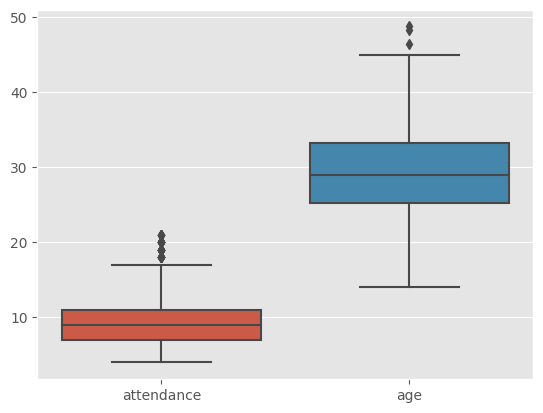

In [10]:
#Checking numeric feature outliers
sns.boxplot(data[['attendance', 'age']])
plt.show()

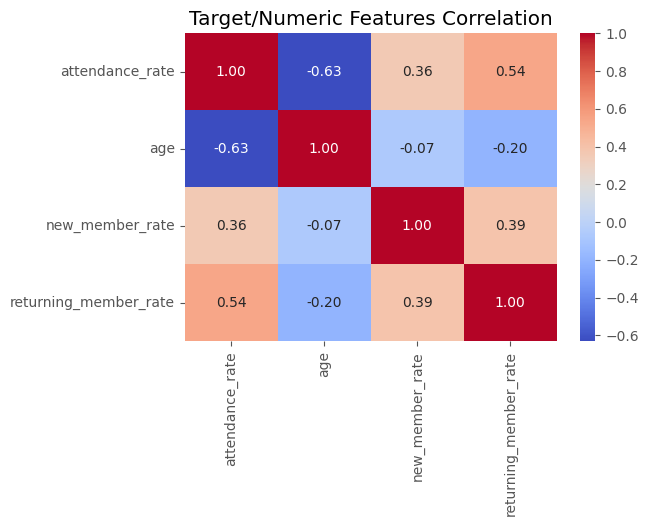

In [11]:
#Inspecting correlations between target and numerical features
num = ['attendance_rate', 'age', 'new_member_rate','returning_member_rate']
fig, ax = plt.subplots(1, figsize=[6,4])
heat = sns.heatmap(data[num].corr(), annot=True, fmt= '.2f', cmap = 'coolwarm')
ax.set_title('Target/Numeric Features Correlation')
plt.show()

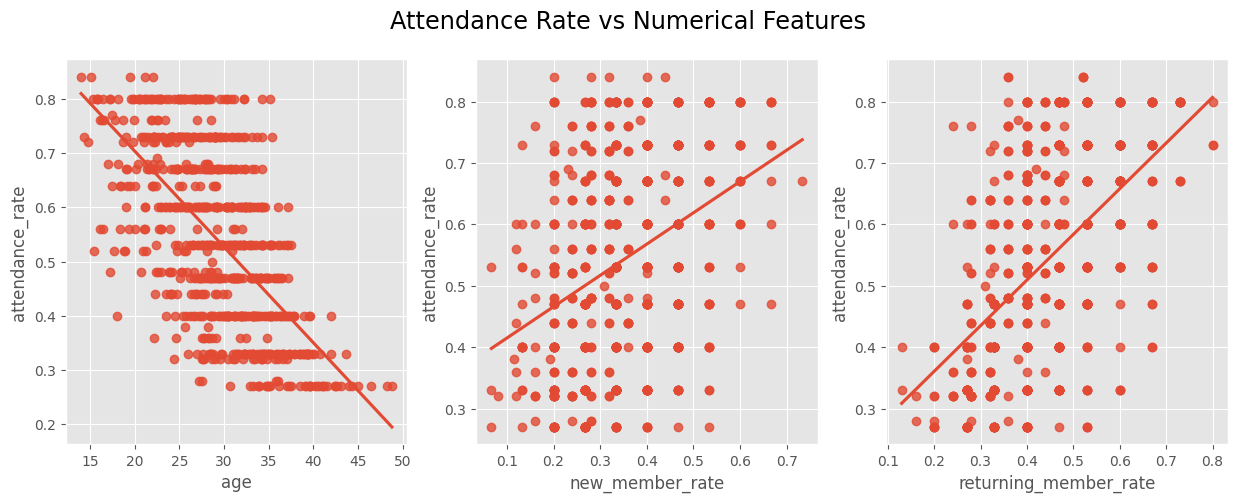

In [12]:
#Inspecting visually the correlation between target and numerical features
fig, axes = plt.subplots(1,3,figsize=(15,5))
sns.regplot(y=data['attendance_rate'],x=data['age'],ax=axes[0],ci=False)
sns.regplot(y=data['attendance_rate'],x=data['new_member_rate'],ax=axes[1],ci=False)
sns.regplot(y=data['attendance_rate'],x=data['returning_member_rate'],ax=axes[2],ci=False)
fig.suptitle('Attendance Rate vs Numerical Features', fontsize='xx-large')
plt.show()

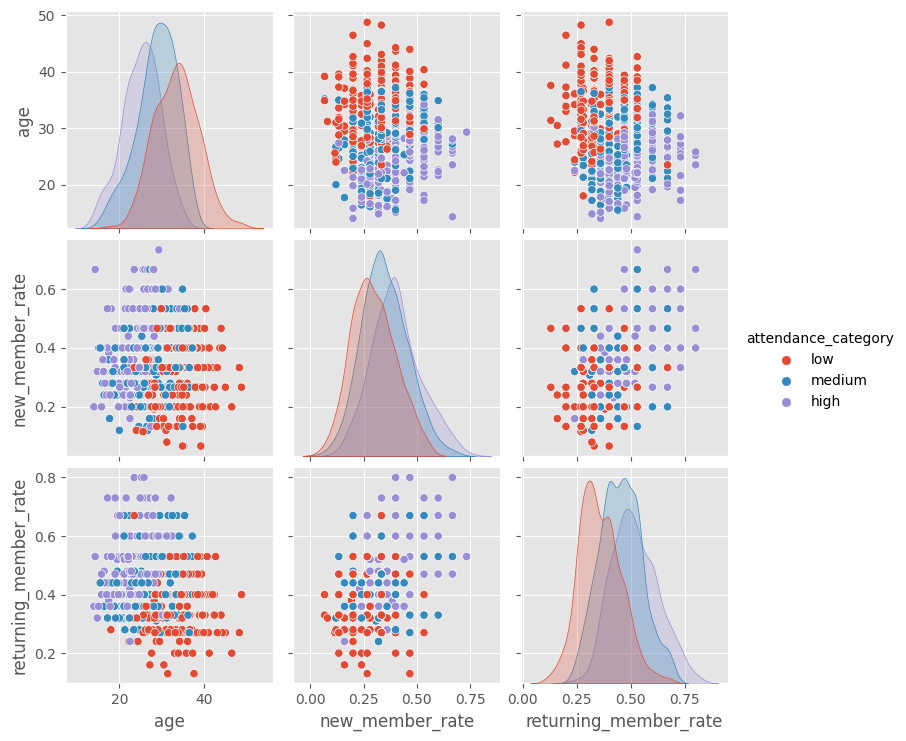

In [13]:
#Inspecting relationship between features 
num_features = ['age', 'new_member_rate','returning_member_rate']
g = sns.pairplot(data, vars = num_features, diag_kind='kde', hue='attendance_category')
plt.show()

### EDA: Inspecting Categorical Features

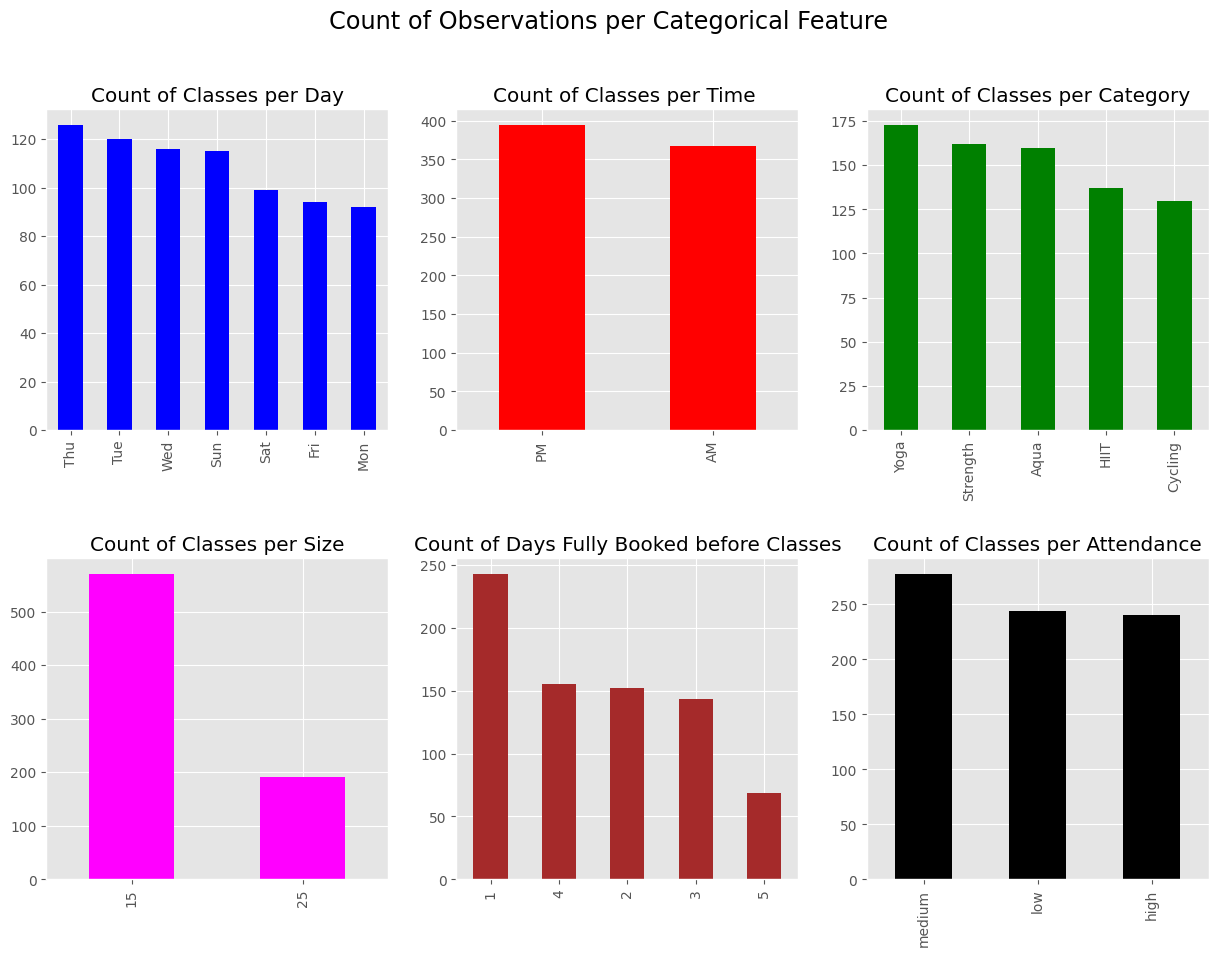

In [14]:
cat_features = ['day_of_week', 'time', 'class_category', 'class_capacity', 'days_before']
fig, ax = plt.subplots(2,3,figsize=(15,10))
plt.subplots_adjust(hspace = 0.4)
data['day_of_week'].value_counts().plot(kind="bar", ax=ax[0,0], color='blue').set(title='Count of Classes per Day')
data['time'].value_counts().plot(kind="bar", ax=ax[0,1], color='red').set(title='Count of Classes per Time ')
data['class_category'].value_counts().plot(kind="bar", ax=ax[0,2], color='green').set(title='Count of Classes per Category')
data['class_capacity'].value_counts().plot(kind="bar", ax=ax[1,0],color='magenta').set(title='Count of Classes per Size')
data['days_before'].value_counts().plot(kind="bar", ax=ax[1,1],color='brown').set(title='Count of Days Fully Booked before Classes')
data['attendance_category'].value_counts().plot(kind="bar", ax=ax[1,2], color='black').set(title='Count of Classes per Attendance')
fig.suptitle('Count of Observations per Categorical Feature', fontsize = 'xx-large')
plt.show()

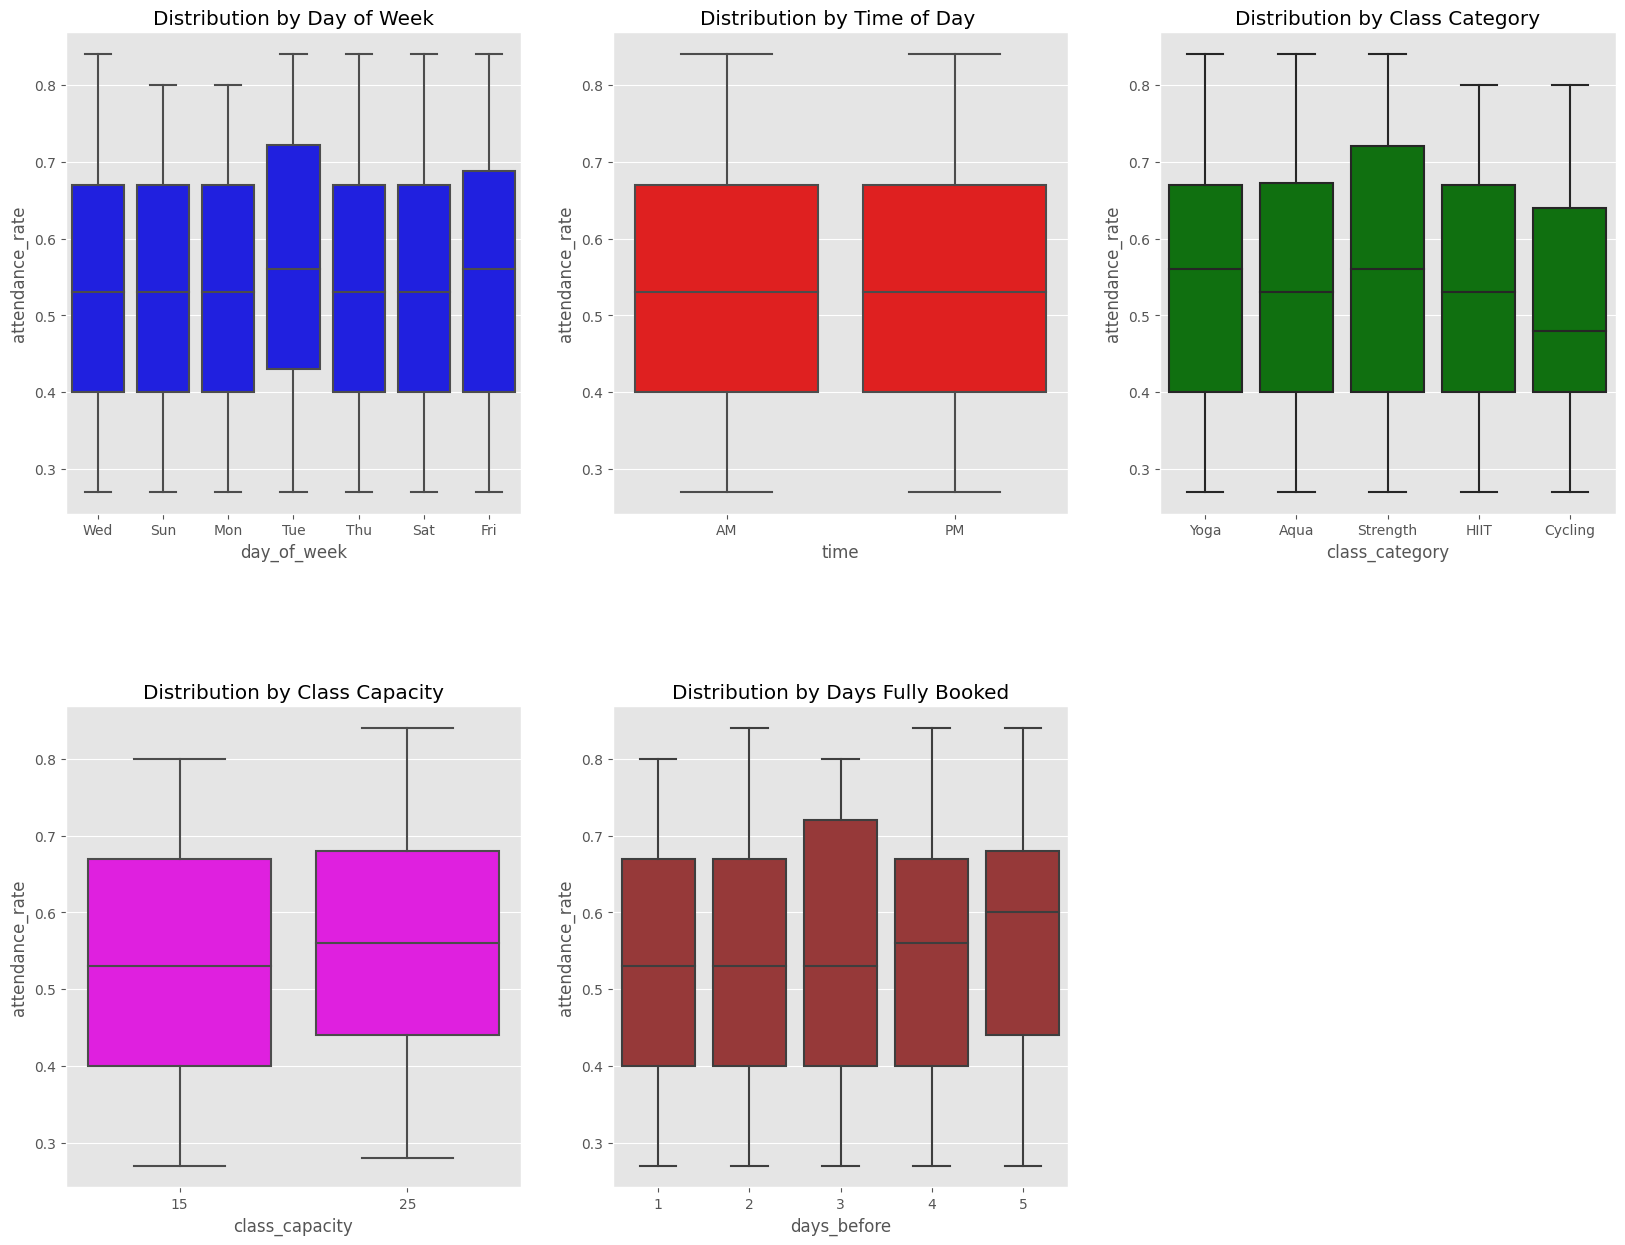

In [15]:
#Inspecting categorical features againist attendance rate
fig, axes = plt.subplots(2,3,figsize=(20,15))
plt.subplots_adjust(hspace = 0.4)
sns.boxplot(x=data['day_of_week'],y=data['attendance_rate'],color='blue',ax=axes[0,0]).set(title='Distribution by Day of Week')
sns.boxplot(x=data['time'],y=data['attendance_rate'],color='red',ax=axes[0,1]).set(title='Distribution by Time of Day ')
sns.boxplot(x=data['class_category'],y=data['attendance_rate'],color='green',ax=axes[0,2]).set(title='Distribution by Class Category')
sns.boxplot(x=data['class_capacity'],y=data['attendance_rate'],color='magenta',ax=axes[1,0]).set(title='Distribution by Class Capacity')
sns.boxplot(x=data['days_before'],y=data['attendance_rate'],color='brown',ax=axes[1,1]).set(title='Distribution by Days Fully Booked')
axes[1,2].remove()
plt.show()

# Exploratory Analysis: Explanantion
___
## Data Visualization: 1 variable
- Used the **boxplot** to check for outliers in original dataset.
- From the 6 different **barplots** of the categorical variables the most frequent categories are: Thursday, PM, yoga, class capacity of 15, 1 day of classes fully booked, and class size of 11.

___
## Data Visualization: 2 or more variables
- From the **pearson corelation heatmap** we can conclude the following linear relationships:
  - "age" and "attendance_rate" have a moderate to strong negative correlation
  - "new_member_rate" and "attendance_rate" have a week to moderate positive correaltion
  - "returning_member_rate" have a moderate positive correlation
- I decided to make **regplots** to further investigate the relationship between "age", "new_member_rate", "returning_member_rate" and our target variable - "attendance_rate".The regplots verify there is a positive linear relationship with two variables ("new_student_rate" and "returning_member_rate") with the target variable, "attendance_rate". Also, there is a negative linear relationship between "age" and "attendance_rate". 
- From the **pairplot** we can verify the relationships between "attendance_level" with age and "new_member_rate" and "returning_member_rate".
 	- I also investigated their relationship between "attendance_rate" using **boxplots.** 
___
## Conclusion:

(boxplot)
1) Outliers are within range of real-world values, so we won't remove them.

(heatmap/scatterplots)
1) The older the age of the member the lower their attendance rate.
2) The more returning members attend the higher the attendance rate. The same relationship holds true for new members but is not as strong. 

(heatmap/pairplot)
1) Both new and returning members attend classes. This shows a higher attendance rate results from a high new member rate, a high returning member rate, or both. 

(pairplot)
1) Younger members attend more classes for both new and returning members.

(barplots/boxplots)
1) "day_of_week": More classes are scheduled for Thursday, but Tuesday has a higher IQR of "attendance_rate" than any other day, which is then followed by Friday.
2) "time": their distributions are nearly the same
3) "class_category": Yoga has the most classes scheduled but strength does get a higher "attendance_rate"
4) "class_capacity":More classes of size 15 are scheduled, but classes of size 25 have a higher IQR of "attendance_rate". 
5) "days_before": classes booked more in advanced have a higher median "attendance_rate"
___
## Changes to Enable Modeling

After the analysis, I decided to apply the following changes to enable modeling:

- Seperate features and target variable
- Split my dataset into a train and test set
- Convert all categorical variables into numeric variables 
- Scaling numeric features to work better with Linear Regression and Ridge Regression


# Model Fitting

## Model Fitting
Predicting the attendance rate for a fitness class at GoalZone is a **multiple regression** problem becasue we are using multiple features to make a prediction. I am choosing Linear Regression as my baseline model because Linear Regression is fast to train and is easily interpretable. The comparison model I am choosing is Ridge Regression because it can handle multicollinearity and can easily be interpreted.

In [16]:
#Preparing the features and target 
features = ['day_of_week', 'time', 'class_category', 'class_capacity',
       'days_before', 'age', 'new_member_rate', 'returning_member_rate']
X = data[features]
y = data['attendance_rate'].values.reshape(-1,1)
print(X.shape, y.shape)

#Splitting the dataset into a train and test set 
X_train, X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state = random_state)

#Tranforming features
preprocessing = ColumnTransformer([
    ('num_features',StandardScaler(), ['age','new_member_rate','returning_member_rate']),
    ('cat_features',OneHotEncoder(), ['day_of_week','time','class_category','class_capacity'])
])

#Fitting baseline and comparison models on our training data
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(X_train, y_train)

ridge = make_pipeline(preprocessing, Ridge())
ridge.fit(X_train, y_train)


(762, 8) (762, 1)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_features',
                                                  StandardScaler(),
                                                  ['age', 'new_member_rate',
                                                   'returning_member_rate']),
                                                 ('cat_features',
                                                  OneHotEncoder(),
                                                  ['day_of_week', 'time',
                                                   'class_category',
                                                   'class_capacity'])])),
                ('ridge', Ridge())])

# Evaluating Model

### Model Evaluation
The metric I used to compare models was the **Root Mean Square Error (RMSE)** becasue the RMSE tells us the typical distance between the predicted value made by the regression model and the actual value. Thus, this metric is easily intepretable and understandable. The Ridge Regression (RMSE=11.059%) just barely beats the Linear Regression (RMSE=11.100%) RMSE score by 0.041%, this means that the ridge regression model on average has a 11.059% error when predicting the attendance rate for a fitness class. This means that the Ridge Regression model predicts more correctly the attendance rate for fitnesses classes at GoalZone.  

In addition to using the RMSE score, we can use the R2 score to show that Ridge Regression (60.578%) is the better model for predicting the attendance rate for a fitness class. 


In [17]:
#Evaluating for R2 score
print('LinearRegression R2: %.3f%%' % (lin_reg.score(X_test, y_test)*100))
print('RidgeRegression R2: %.3f%%' % (ridge.score(X_test, y_test)*100))

LinearRegression R2: 60.567%
RidgeRegression R2: 60.578%


In [18]:
#Cross Validating for Root Mean Squared Error (RMSE)
lin_reg_rmses = (-cross_val_score(estimator = lin_reg, 
                                 X = X_test, 
                                 y = y_test,
                                 scoring = 'neg_mean_squared_error', 
                                 cv = KFold(n_splits=10, random_state=random_state, shuffle=True),
                                 n_jobs = -1))**(1/2)
print('lin Reg Kfold RMSE: %.3f%%' % (np.mean(lin_reg_rmses)*100))

ridge_rmses = (-cross_val_score(estimator = ridge, 
                                 X = X_test, 
                                 y = y_test,
                                 scoring = 'neg_mean_squared_error', 
                                 cv = KFold(n_splits=10, random_state=random_state, shuffle=True),
                                 n_jobs = -1))**(1/2)
print('ridge Kfold RMSE: %.3f%%' % (np.mean(ridge_rmses)*100))

lin Reg Kfold RMSE: 11.100%
ridge Kfold RMSE: 11.059%
